# Mango Leaf Disease Classification - 10 Steps Pipeline 

---
## STEP 1. Problem Understanding

### Mô tả bài toán
Xây dựng một mô hình **Deep Learning** nhằm tự động nhận diện các bệnh và tổn thương trên lá cây xoài dựa trên ảnh RGB thu thập từ thực tế.

| Thuộc tính | Mô tả |
|------------|-------|
| **Loại bài toán** | Supervised Learning - Classification |
| **Input** | Ảnh RGB của lá xoài (224×224 pixels) |
| **Output** | Một trong 9 lớp bệnh hoặc trạng thái lá khỏe |

### Mục tiêu nghiên cứu
- Xây dựng **pipeline hoàn chỉnh** từ dữ liệu → mô hình → đánh giá
- So sánh hiệu quả giữa các mô hình Deep Learning** (EfficientNet, MobileNet, ResNet, VGG, DenseNet, Inception, ...)


In [17]:
# Cài đặt các thư viện cần thiết 
!pip install tensorflow numpy pandas matplotlib seaborn pillow scikit-learn tqdm -q


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [18]:
# Import các thư viện cần thiết
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.applications import (
    EfficientNetB0, MobileNetV2, ResNet50, 
    VGG16, DenseNet121, InceptionV3
)
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cấu hình GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {gpus}")

# Set AUTOTUNE cho tf.data pipeline
AUTOTUNE = tf.data.AUTOTUNE

TensorFlow version: 2.20.0
GPU Available: []


In [19]:
# Cấu hình
DATA_DIR = "./MangoLeaf_Dataset"

---
## STEP 2. Data Understanding

Kiểm tra:
- Missing Values?
- Outliers (Noise)?
- Inconsistent data?
- Imbalanced classes?
- Skewness?

In [20]:
# Thống kê số lượng ảnh theo từng lớp
classes = sorted(os.listdir(DATA_DIR))
stats = []
for c in classes:
    class_path = os.path.join(DATA_DIR, c)
    num_images = len(os.listdir(class_path))
    stats.append({"Class": c, "Num_Images": num_images})

df_stats = pd.DataFrame(stats)
print("=" * 50)
print("THỐNG KÊ DATASET")
print("=" * 50)
print(df_stats.to_string(index=False))
print(f"\nTổng số ảnh: {df_stats['Num_Images'].sum()}")
print(f"Số lớp: {len(classes)}")
print(f"\nMissing Values: Không có (tất cả ảnh đều tồn tại)")
print(f"Imbalanced: {'Có' if df_stats['Num_Images'].std() > 30 else 'Không'}")

THỐNG KÊ DATASET
           Class  Num_Images
     Anthracnose         390
Bacterial_Canker         400
  Bacterial_Spot         391
  Cutting_Weevil         400
        Die_Back         396
      Gall_Midge         400
         Healthy         400
  Powdery_Mildew         400
     Sooty_Mould         400

Tổng số ảnh: 3577
Số lớp: 9

Missing Values: Không có (tất cả ảnh đều tồn tại)
Imbalanced: Không


In [21]:
# Kiểm tra kích thước ảnh trong dataset
print("=" * 50)
print("KIỂM TRA KÍCH THƯỚC ẢNH")
print("=" * 50)

sample_sizes = []
for c in classes[:3]:  # Lấy mẫu 3 class đầu
    class_path = os.path.join(DATA_DIR, c)
    for img_name in os.listdir(class_path)[:5]:
        img = Image.open(os.path.join(class_path, img_name))
        sample_sizes.append({"Class": c, "Width": img.size[0], "Height": img.size[1]})

df_sample = pd.DataFrame(sample_sizes)
print(df_sample)
print(f"\n→ Kích thước phổ biến: {df_sample['Width'].mode()[0]}x{df_sample['Height'].mode()[0]}")

KIỂM TRA KÍCH THƯỚC ẢNH
               Class  Width  Height
0        Anthracnose    224     224
1        Anthracnose    224     224
2        Anthracnose    224     224
3        Anthracnose    224     224
4        Anthracnose    224     224
5   Bacterial_Canker    224     224
6   Bacterial_Canker    224     224
7   Bacterial_Canker    224     224
8   Bacterial_Canker    224     224
9   Bacterial_Canker    224     224
10    Bacterial_Spot    224     224
11    Bacterial_Spot    224     224
12    Bacterial_Spot    224     224
13    Bacterial_Spot    224     224
14    Bacterial_Spot    224     224

→ Kích thước phổ biến: 224x224


In [22]:
# Hiểu loại dữ liệu
print("=" * 50)
print("LOẠI DỮ LIỆU")
print("=" * 50)

# Lấy mẫu 1 ảnh để phân tích
sample_class = classes[0]
sample_img_path = os.path.join(DATA_DIR, sample_class, os.listdir(os.path.join(DATA_DIR, sample_class))[0])
sample_img = Image.open(sample_img_path)

print(f"Định dạng ảnh: {sample_img.format}")
print(f"Kích thước (W x H): {sample_img.size[0]} x {sample_img.size[1]} pixels")
print(f"Chế độ màu: {sample_img.mode} ({'RGB - 3 kênh màu' if sample_img.mode == 'RGB' else sample_img.mode})")
print(f"Kiểu dữ liệu pixel: uint8 (0-255)")

# Thống kê các định dạng file trong dataset
formats = {}
for c in classes:
    class_path = os.path.join(DATA_DIR, c)
    for img_name in os.listdir(class_path)[:10]:
        ext = img_name.split('.')[-1].lower()
        formats[ext] = formats.get(ext, 0) + 1


LOẠI DỮ LIỆU
Định dạng ảnh: JPEG
Kích thước (W x H): 224 x 224 pixels
Chế độ màu: RGB (RGB - 3 kênh màu)
Kiểu dữ liệu pixel: uint8 (0-255)


---
## STEP 3. Feature Understanding (EDA)

- **Univariate Analysis:** Phân tích từng lớp riêng lẻ
- **Bivariate Analysis:** So sánh giữa các lớp
- **Multivariate Analysis:** Phân tích đa chiều (RGB channels)

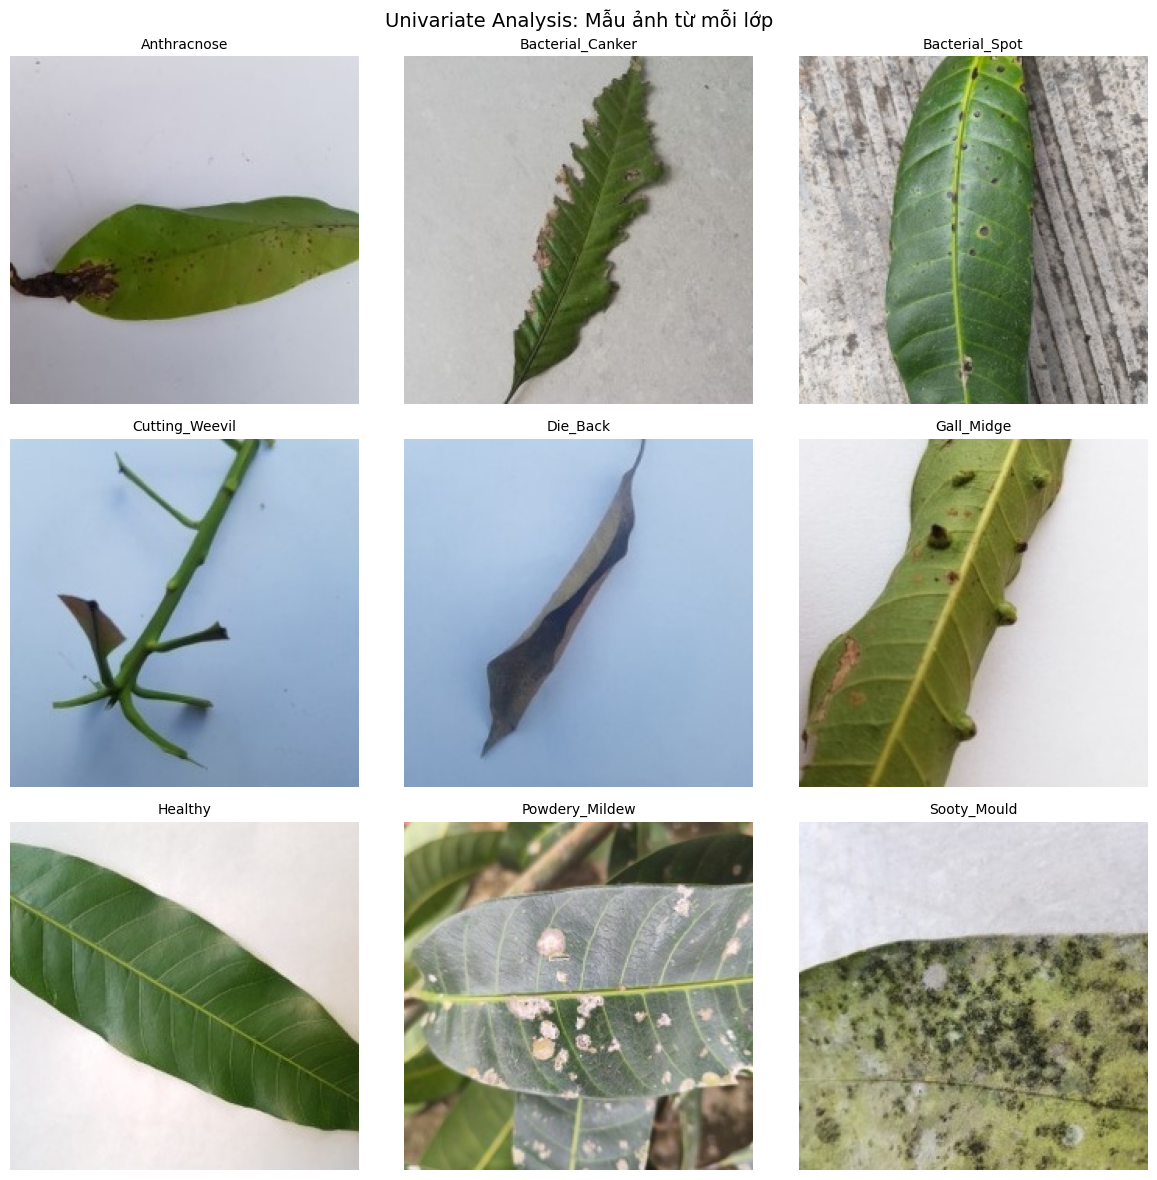

In [23]:
# Univariate: Hiển thị mẫu ảnh từ mỗi lớp
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for idx, c in enumerate(classes):
    class_path = os.path.join(DATA_DIR, c)
    img_name = os.listdir(class_path)[0]
    img = Image.open(os.path.join(class_path, img_name))
    axes[idx].imshow(img)
    axes[idx].set_title(c, fontsize=10)
    axes[idx].axis('off')

plt.suptitle("Univariate Analysis: Mẫu ảnh từ mỗi lớp", fontsize=14)
plt.tight_layout()
plt.show()

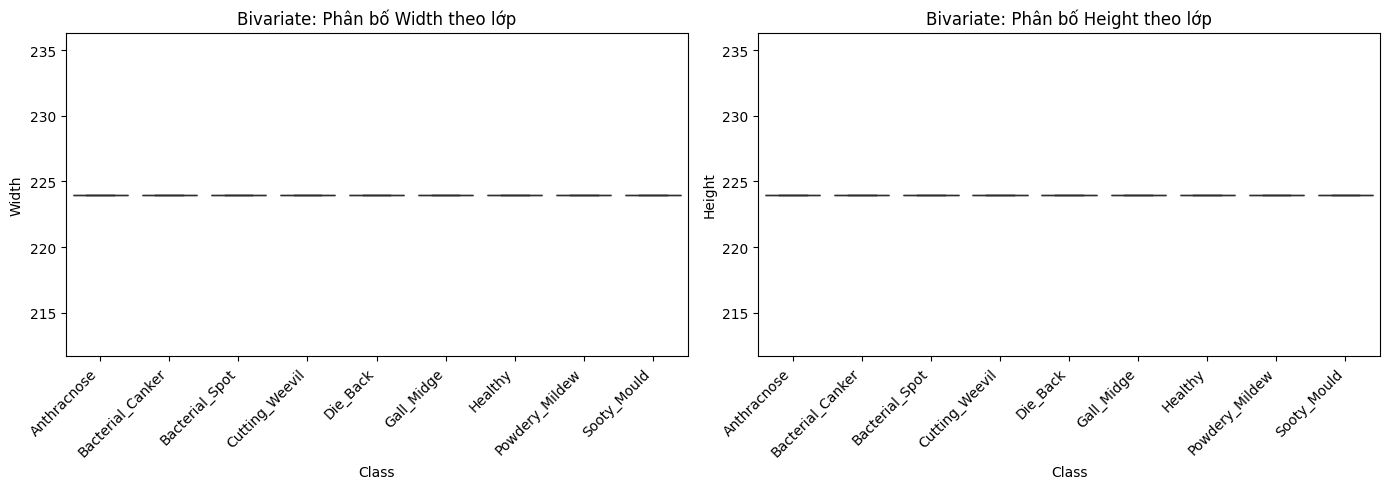

In [24]:
# Bivariate: Phân tích kích thước ảnh theo lớp
size_data = []
for c in classes:
    class_path = os.path.join(DATA_DIR, c)
    for img_name in os.listdir(class_path)[:30]:  # Lấy mẫu 30 ảnh/lớp
        img = Image.open(os.path.join(class_path, img_name))
        w, h = img.size
        size_data.append({"Class": c, "Width": w, "Height": h})

df_size = pd.DataFrame(size_data)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=df_size, x="Class", y="Width", ax=axes[0], palette="viridis")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("Bivariate: Phân bố Width theo lớp")

sns.boxplot(data=df_size, x="Class", y="Height", ax=axes[1], palette="viridis")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("Bivariate: Phân bố Height theo lớp")

plt.tight_layout()
plt.show()

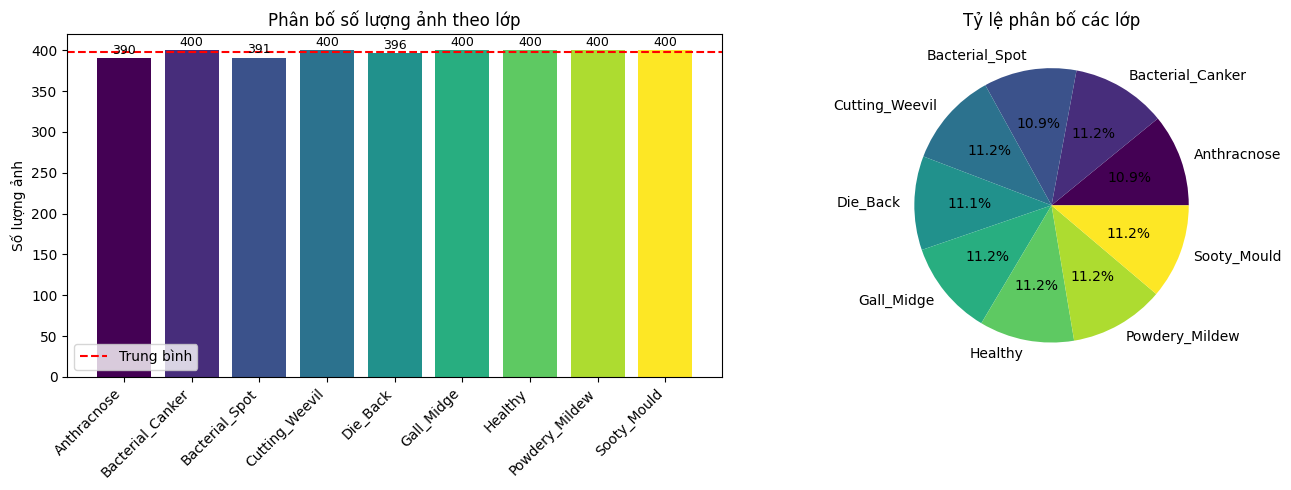


📊 Min: 390 | Max: 400 | Mean: 397


In [25]:
# Biểu đồ phân bố số lượng ảnh theo lớp
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = plt.cm.viridis(np.linspace(0, 1, len(df_stats)))
bars = axes[0].bar(df_stats['Class'], df_stats['Num_Images'], color=colors)
axes[0].set_xticklabels(df_stats['Class'], rotation=45, ha='right')
axes[0].set_ylabel('Số lượng ảnh')
axes[0].set_title('Phân bố số lượng ảnh theo lớp')
axes[0].axhline(y=df_stats['Num_Images'].mean(), color='r', linestyle='--', label='Trung bình')

# Thêm số liệu trên bar
for bar in bars:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 int(bar.get_height()), ha='center', fontsize=9)
axes[0].legend()

# Pie chart
axes[1].pie(df_stats['Num_Images'], labels=df_stats['Class'], autopct='%1.1f%%', colors=colors)
axes[1].set_title('Tỷ lệ phân bố các lớp')

plt.tight_layout()
plt.show()

# Đánh giá cân bằng
print(f"\n📊 Min: {df_stats['Num_Images'].min()} | Max: {df_stats['Num_Images'].max()} | Mean: {df_stats['Num_Images'].mean():.0f}")

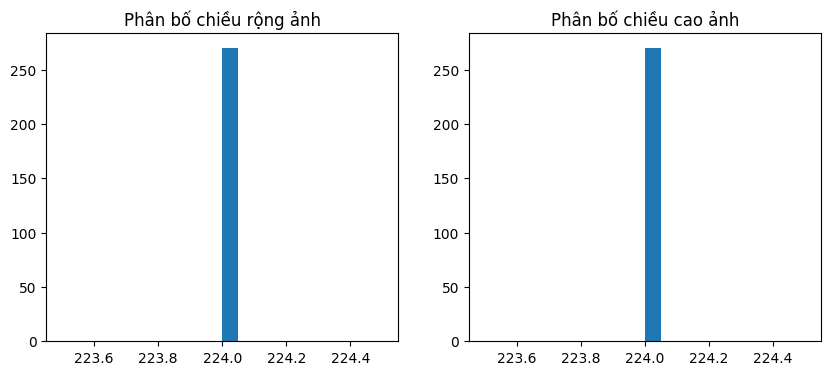

In [26]:
# Phân bố kích thước ảnh (Width và Height)
widths, heights = [], []

for cls in classes:
    imgs = os.listdir(os.path.join(DATA_DIR, cls))[:30]
    for img_name in imgs:
        img = Image.open(os.path.join(DATA_DIR, cls, img_name))
        w, h = img.size
        widths.append(w)
        heights.append(h)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(widths, bins=20)
plt.title("Phân bố chiều rộng ảnh")

plt.subplot(1,2,2)
plt.hist(heights, bins=20)
plt.title("Phân bố chiều cao ảnh")
plt.show()


---
## STEP 4. Feature Engineering

- **Skewness/Outlier Handling:** Class weights cho imbalanced data
- **Feature Transformation:** Resize về 224x224
- **Feature Scaling:** Normalize [0,1]
- **Data Augmentation:** Rotation, Flip, Zoom, Shift

In [27]:
# 4.1. Đánh giá có cần Class Weights không?
print("=" * 50)
print("ĐÁNH GIÁ CÂN BẰNG DỮ LIỆU")
print("=" * 50)

# Tính tỷ lệ chênh lệch
max_samples = df_stats['Num_Images'].max()
min_samples = df_stats['Num_Images'].min()
imbalance_ratio = max_samples / min_samples

print(f"  Max: {max_samples} ảnh")
print(f"  Min: {min_samples} ảnh")
print(f"  Tỷ lệ Max/Min: {imbalance_ratio:.3f}")
print(f"  Độ lệch chuẩn: {df_stats['Num_Images'].std():.2f}")

print("\n" + "=" * 50)
print("QUYẾT ĐỊNH")
print("=" * 50)

if imbalance_ratio < 1.5:
    print("✅ Dataset CÂN BẰNG TỐT (tỷ lệ < 1.5)")
    print("→ KHÔNG CẦN sử dụng Class Weights")
    class_weights = None
else:
    print("⚠️ Dataset MẤT CÂN BẰNG (tỷ lệ >= 1.5)")
    print("→ CẦN sử dụng Class Weights")
    total_images = df_stats['Num_Images'].sum()
    class_weights = {}
    for idx, row in df_stats.iterrows():
        class_weights[idx] = total_images / (len(classes) * row['Num_Images'])

print(f"\n→ class_weights = {class_weights}")

ĐÁNH GIÁ CÂN BẰNG DỮ LIỆU
  Max: 400 ảnh
  Min: 390 ảnh
  Tỷ lệ Max/Min: 1.026
  Độ lệch chuẩn: 4.16

QUYẾT ĐỊNH
✅ Dataset CÂN BẰNG TỐT (tỷ lệ < 1.5)
→ KHÔNG CẦN sử dụng Class Weights

→ class_weights = None


In [28]:
# 4.2. Cấu hình tham số
IMG_SIZE = (224, 224)  # Kích thước ảnh sau khi resize
BATCH_SIZE = 32
SEED = 42
NUM_CLASSES = len(classes)

In [29]:
# 4.3. Data Augmentation (sử dụng Keras Preprocessing Layers - chạy trên GPU)
def create_augmentation_layers():
    """Tạo data augmentation layers"""
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.1),
    ], name='augmentation')

data_augmentation = create_augmentation_layers()

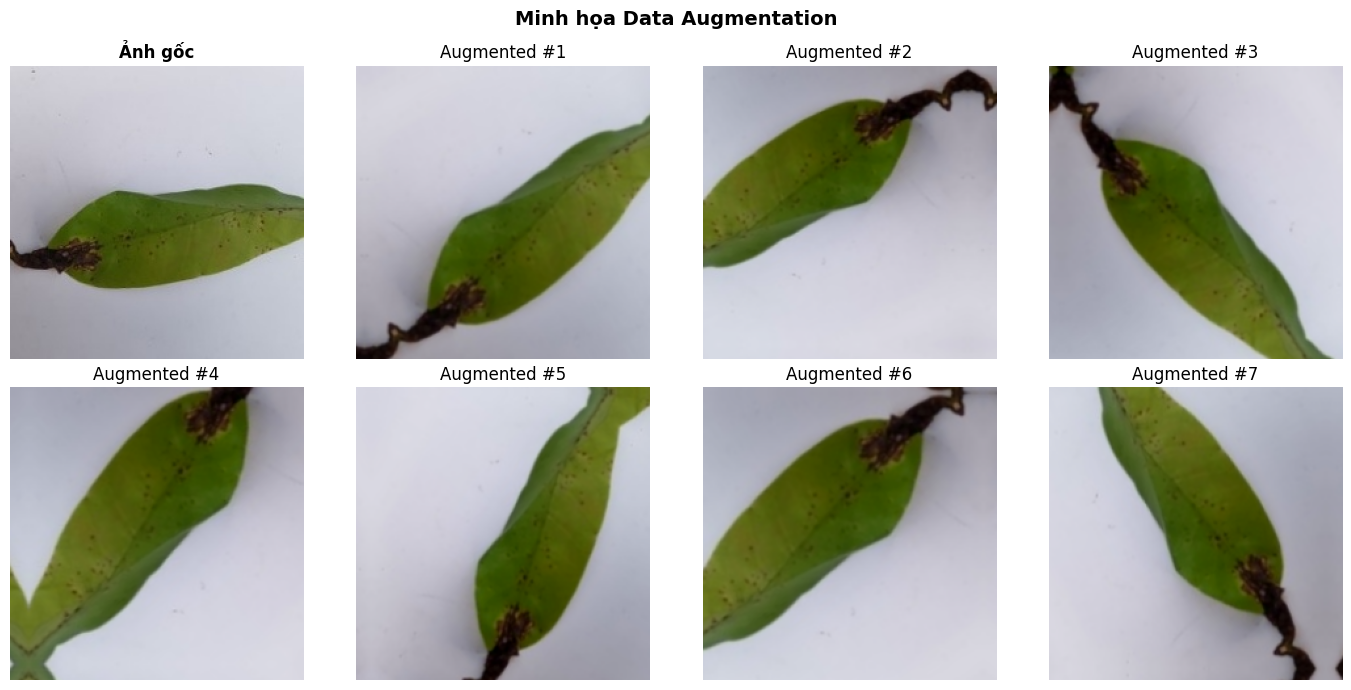

In [30]:
# 4.4. Minh họa Data Augmentation
sample_class = classes[0]
sample_img_path = os.path.join(DATA_DIR, sample_class, os.listdir(os.path.join(DATA_DIR, sample_class))[0])
sample_img = tf.keras.utils.load_img(sample_img_path, target_size=IMG_SIZE)
sample_array = tf.keras.utils.img_to_array(sample_img)
sample_array = tf.expand_dims(sample_array, 0)

# Hiển thị ảnh gốc và các phiên bản augmented
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

axes[0].imshow(sample_img)
axes[0].set_title("Ảnh gốc", fontweight='bold')
axes[0].axis('off')

for i in range(1, 8):
    augmented = data_augmentation(sample_array, training=True)
    axes[i].imshow(augmented[0].numpy().astype('uint8'))
    axes[i].set_title(f"Augmented #{i}")
    axes[i].axis('off')

plt.suptitle("Minh họa Data Augmentation", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()